In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
from collections import OrderedDict
from tqdm import tqdm

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1
DATASET_VERSION = "04"

In [4]:
OUT_PATH = Path(f"../data/pfi/")

if not OUT_PATH.exists():
    OUT_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
#categ_feats = [
#    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
#    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
#    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
#    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
#]
len(input_feats)

1639

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

36

***
## model training

In [8]:
model_params = {
    'boosting':'gbdt',
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    oof_dfs = list()
    
    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            #categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            #categorical_feature=categ_feats,
            free_raw_data=True,
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=3000,
            callbacks=[
                lgb.log_evaluation(period=50), 
                lgb.early_stopping(300, first_metric_only=True)
            ],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        valid_df.loc[:,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        oof_dfs.append(valid_df)
        del train_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof_dfs

############################### repeated cross-validation step: 1/1 ################################
######################################## training model 1/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.765494	valid_0's recall_at4: 0.622318	valid_0's norm_gini: 0.90867
[100]	valid_0's amex_metric: 0.77991	valid_0's recall_at4: 0.643945	valid_0's norm_gini: 0.915875
[150]	valid_0's amex_metric: 0.786201	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.91941
[200]	valid_0's amex_metric: 0.789801	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.921352
[250]	valid_0's amex_metric: 0.791254	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.922448
[300]	valid_0's amex_metric: 0.794456	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.923172
[350]	valid_0's amex_metric: 0.795428	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.923642
[400]	valid_0's amex_metric: 0.796014	valid_0's

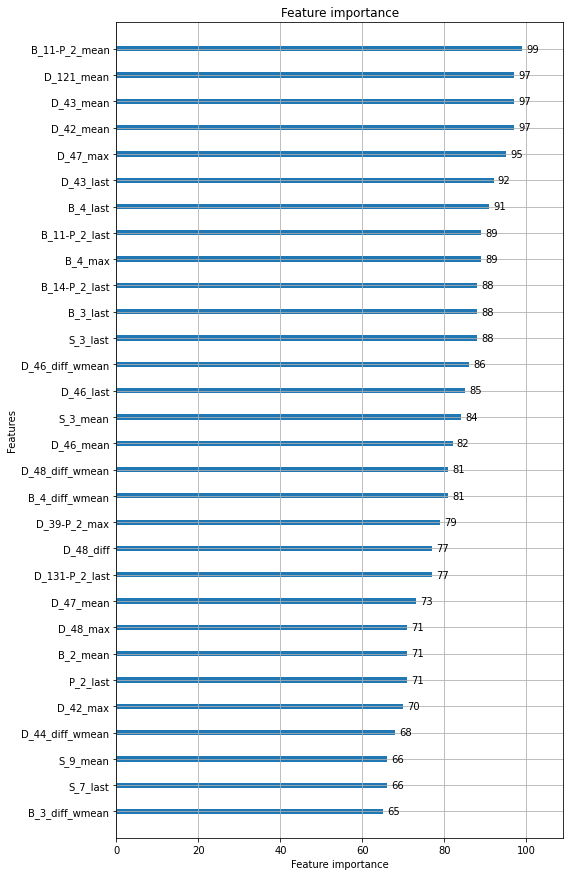

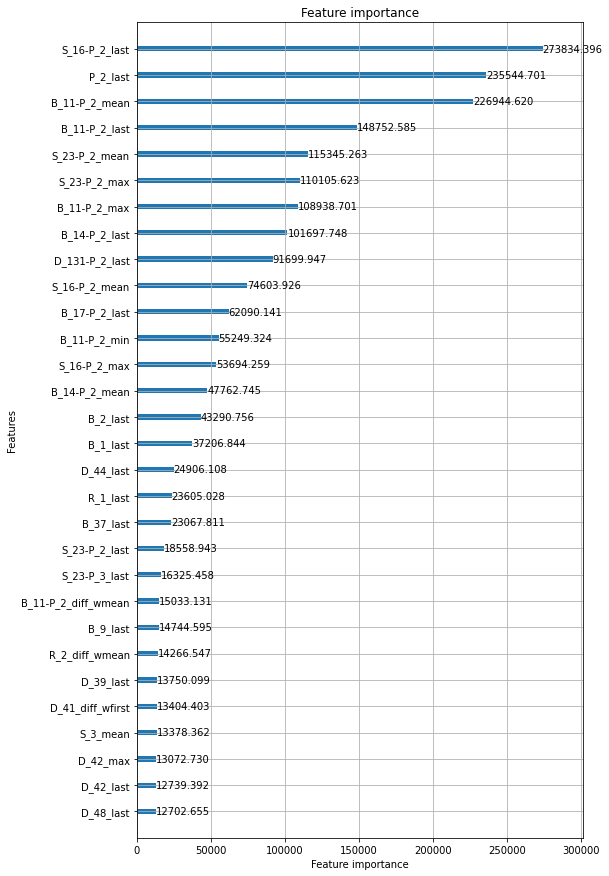

######################################## training model 2/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.763497	valid_0's recall_at4: 0.619625	valid_0's norm_gini: 0.907368
[100]	valid_0's amex_metric: 0.77574	valid_0's recall_at4: 0.63696	valid_0's norm_gini: 0.914519
[150]	valid_0's amex_metric: 0.783809	valid_0's recall_at4: 0.649331	valid_0's norm_gini: 0.918288
[200]	valid_0's amex_metric: 0.78734	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.920342
[250]	valid_0's amex_metric: 0.791049	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.921533
[300]	valid_0's amex_metric: 0.791874	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.9223
[350]	valid_0's amex_metric: 0.792228	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922838
[400]	valid_0's amex_metric: 0.79319	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.923206
[450]	valid_0's amex_metric: 0.793464	valid_0's reca

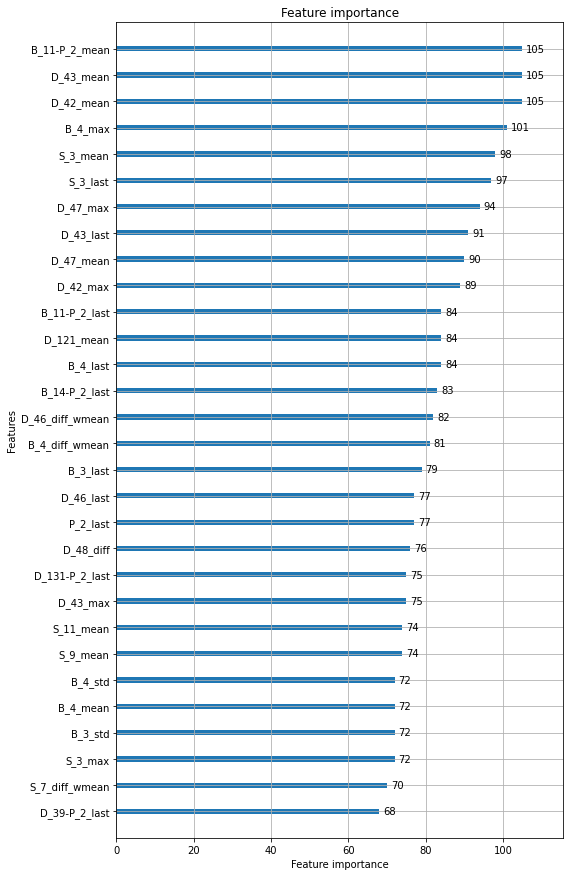

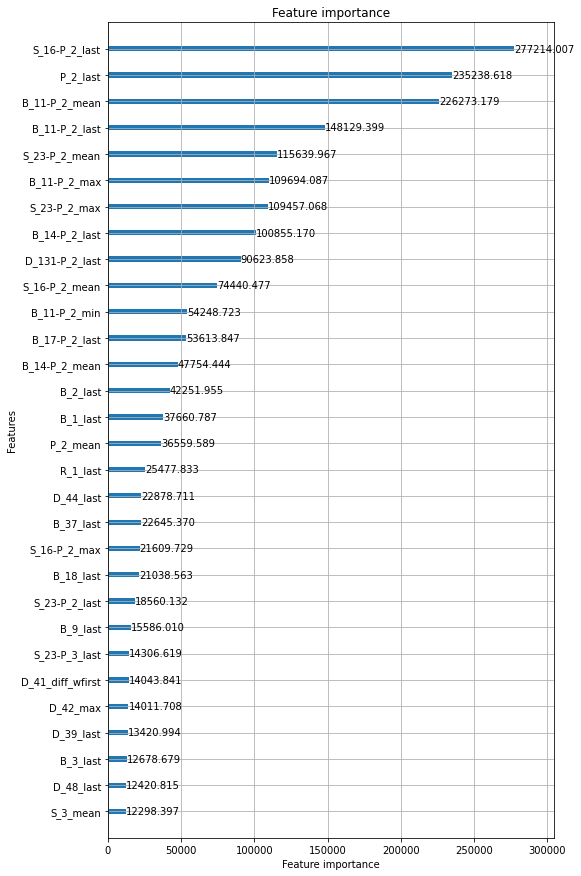

######################################## training model 3/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.759452	valid_0's recall_at4: 0.612219	valid_0's norm_gini: 0.906685
[100]	valid_0's amex_metric: 0.771926	valid_0's recall_at4: 0.630228	valid_0's norm_gini: 0.913625
[150]	valid_0's amex_metric: 0.778525	valid_0's recall_at4: 0.639906	valid_0's norm_gini: 0.917145
[200]	valid_0's amex_metric: 0.782315	valid_0's recall_at4: 0.645544	valid_0's norm_gini: 0.919085
[250]	valid_0's amex_metric: 0.784598	valid_0's recall_at4: 0.649036	valid_0's norm_gini: 0.92016
[300]	valid_0's amex_metric: 0.786579	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.920924
[350]	valid_0's amex_metric: 0.787638	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.921443
[400]	valid_0's amex_metric: 0.787339	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.921812
[450]	valid_0's amex_metric: 0.787262	valid_0's

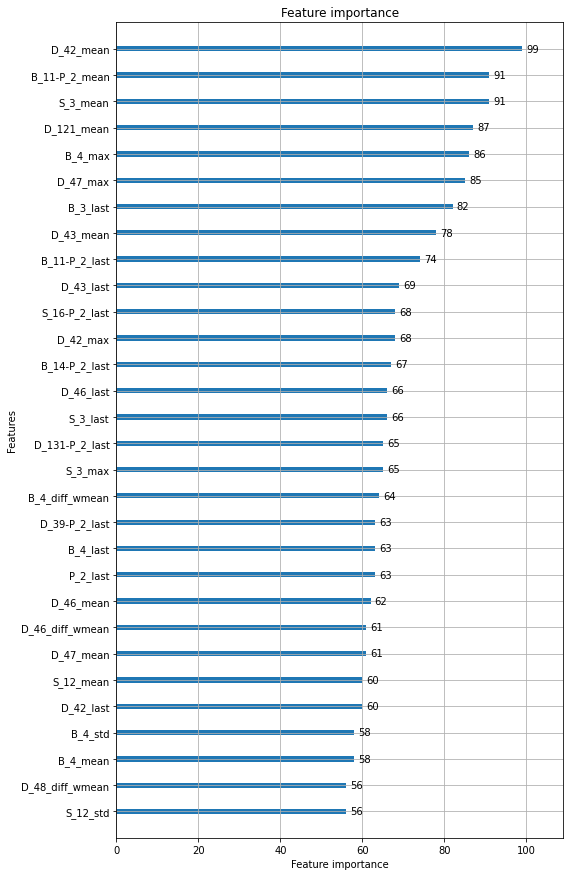

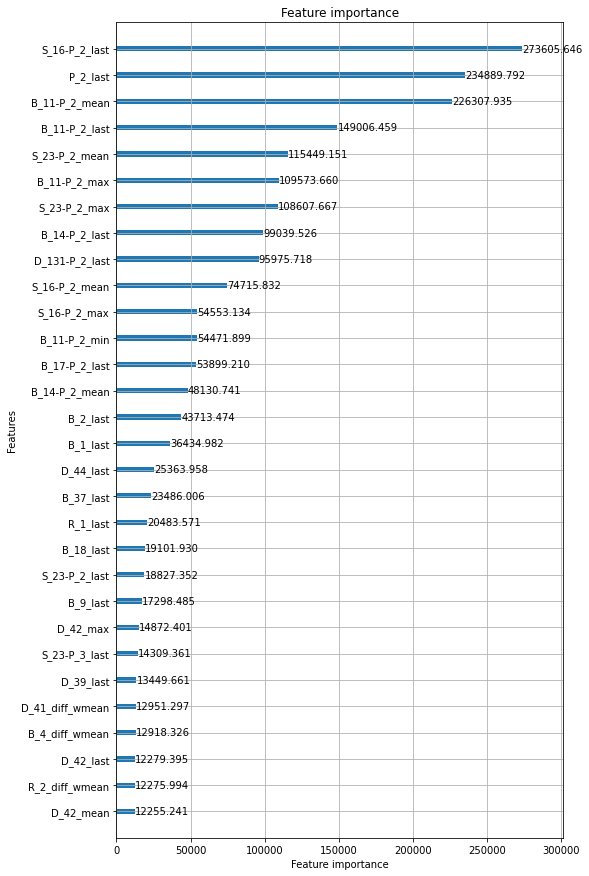

######################################## training model 4/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.760142	valid_0's recall_at4: 0.61397	valid_0's norm_gini: 0.906314
[100]	valid_0's amex_metric: 0.773085	valid_0's recall_at4: 0.632695	valid_0's norm_gini: 0.913476
[150]	valid_0's amex_metric: 0.778668	valid_0's recall_at4: 0.640059	valid_0's norm_gini: 0.917276
[200]	valid_0's amex_metric: 0.782543	valid_0's recall_at4: 0.645782	valid_0's norm_gini: 0.919304
[250]	valid_0's amex_metric: 0.783928	valid_0's recall_at4: 0.647296	valid_0's norm_gini: 0.92056
[300]	valid_0's amex_metric: 0.785562	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.921429
[350]	valid_0's amex_metric: 0.786493	valid_0's recall_at4: 0.650957	valid_0's norm_gini: 0.922028
[400]	valid_0's amex_metric: 0.787505	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.922455
[450]	valid_0's amex_metric: 0.78799	valid_0's r

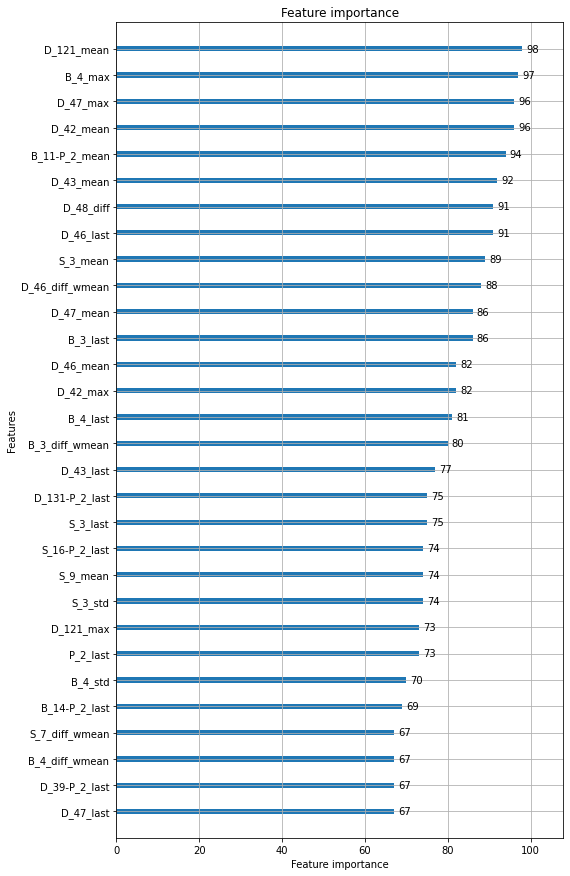

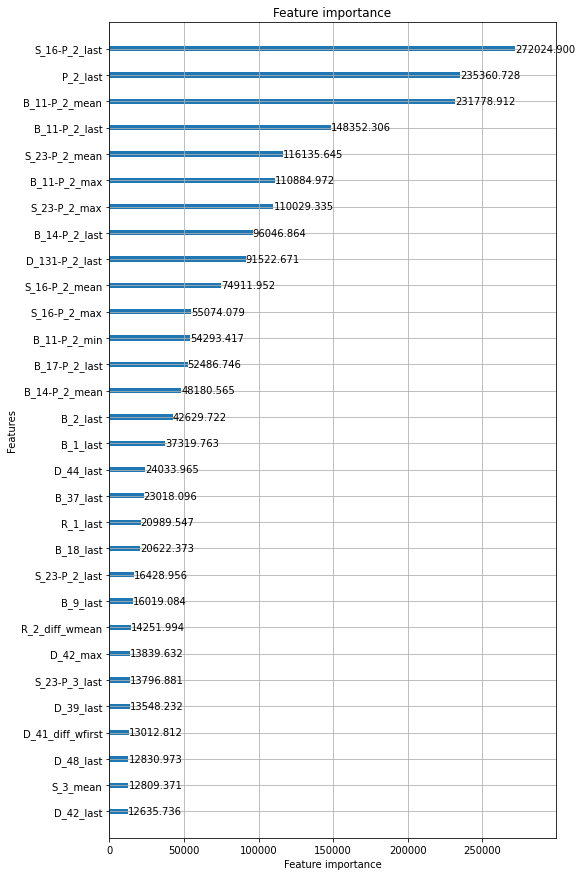

######################################## training model 5/5 ########################################
Training until validation scores don't improve for 300 rounds
[50]	valid_0's amex_metric: 0.767468	valid_0's recall_at4: 0.625163	valid_0's norm_gini: 0.909773
[100]	valid_0's amex_metric: 0.780988	valid_0's recall_at4: 0.644982	valid_0's norm_gini: 0.916995
[150]	valid_0's amex_metric: 0.787936	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.920538
[200]	valid_0's amex_metric: 0.791961	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.922445
[250]	valid_0's amex_metric: 0.794067	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.923542
[300]	valid_0's amex_metric: 0.79551	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.924242
[350]	valid_0's amex_metric: 0.795886	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.924782
[400]	valid_0's amex_metric: 0.796765	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925152
[450]	valid_0's amex_metric: 0.79716	valid_0's 

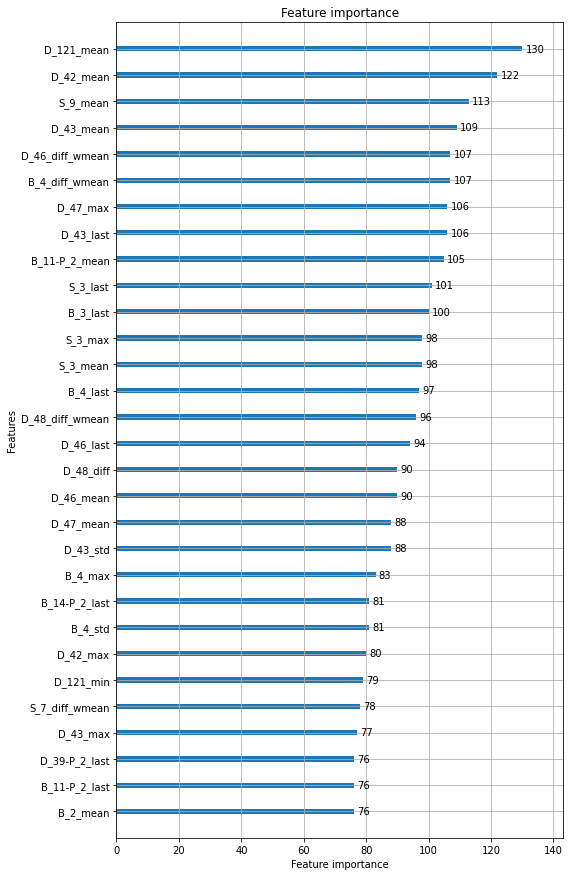

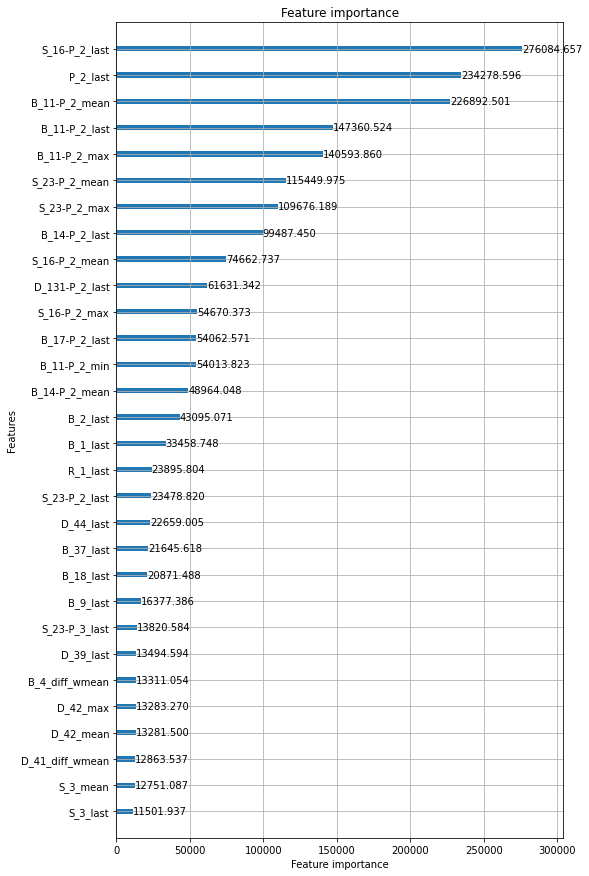

Training time: 25.200138727823894 min.
CPU times: user 5h 14min 52s, sys: 41.8 s, total: 5h 15min 34s
Wall time: 25min 16s


In [10]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof_dfs = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
              
    all_models.extend(models)
    all_oof_dfs.extend(oof_dfs)
              
    del _train, folds; gc.collect()

***
## computes PFI

In [11]:
def compute_pfi(
        model:lgb.Booster,
        dataframe:pd.DataFrame, 
        features:list, 
        target:str
    ):
    
    # calculates base score
    preds = model.predict(dataframe[features])
    target = dataframe[target].values
    BASE_SCORE = compute_amex_metric(target, preds)

    output = OrderedDict()
    output["base_score"] = BASE_SCORE

    # calculates pfi for each feature
    for col in tqdm(features):
        _dataframe = dataframe.copy()
        index = np.random.permutation(_dataframe.index.values)
        _dataframe[col] = _dataframe.loc[index,col].values
        preds = model.predict(_dataframe[features])
        score = compute_amex_metric(target, preds)
        pfi = (BASE_SCORE - score)
        output[col] = pfi
        
        del _dataframe; gc.collect()
    
    return output

In [13]:
for model,oof_df in zip(all_models,all_oof_dfs):
    break

In [ ]:
%%timeit -n 10 
model.predict(oof_df[input_feats])

In [ ]:
import daal4py as d4p
import lleaves

***
### testing daal4py

In [58]:
daal_model = d4p.get_gbt_model_from_lightgbm(model)
daal_model

NotImplementedError: Categorical features are not supported in daal4py Gradient Boosting Trees

In [67]:
model.save_model("tmp-lgbm.txt")
llvm_model = lleaves.Model("tmp-lgbm.txt")
llvm_model.compile()

In [70]:
%%timeit
llvm_model.predict(oof_df[input_feats])

1.93 s ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%time
output = compute_pfi(
    model=model,
    dataframe=oof_df,
    features=input_feats,
    target="target",
)

100% 1562/1562 [1:03:19<00:00,  2.43s/it]

CPU times: user 6h 56min 40s, sys: 1.86 s, total: 6h 56min 42s
Wall time: 1h 3min 21s


In [49]:
output_df = pd.DataFrame([output,])
output_df

,base_score,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_2_mean,B_2_std,B_2_min,B_2_max,B_2_last,R_1_mean,R_1_std,R_1_min,R_1_max,R_1_last,S_3_mean,S_3_std,S_3_min,S_3_max,S_3_last,D_41_mean,D_41_std,D_41_min,D_41_max,D_41_last,B_3_mean,B_3_std,B_3_min,B_3_max,B_3_last,D_42_mean,D_42_std,D_42_min,D_42_max,D_42_last,D_43_mean,D_43_std,D_43_min,D_43_max,D_43_last,D_44_mean,D_44_std,D_44_min,D_44_max,D_44_last,B_4_mean,B_4_std,B_4_min,B_4_max,B_4_last,D_45_mean,D_45_std,D_45_min,D_45_max,D_45_last,B_5_mean,B_5_std,B_5_min,B_5_max,B_5_last,R_2_mean,R_2_std,R_2_min,R_2_max,R_2_last,D_46_mean,D_46_std,D_46_min,D_46_max,D_46_last,D_47_mean,D_47_std,D_47_min,D_47_max,D_47_last,D_48_mean,D_48_std,D_48_min,D_48_max,D_48_last,D_49_mean,D_49_std,D_49_min,D_49_max,D_49_last,B_6_mean,B_6_std,B_6_min,B_6_max,B_6_last,B_7_mean,B_7_std,B_7_min,B_7_max,B_7_last,B_8_mean,B_8_std,B_8_min,B_8_max,B_8_last,D_50_mean,D_50_std,D_50_min,D_50_max,D_50_last,D_51_mean,D_51_std,D_51_min,D_51_max,D_51_last,B_9_mean,B_9_std,B_9_min,B_9_max,B_9_last,R_3_mean,R_3_std,R_3_min,R_3_max,R_3_last,D_52_mean,D_52_std,D_52_min,D_52_max,D_52_last,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,B_10_mean,B_10_std,B_10_min,B_10_max,B_10_last,D_53_mean,D_53_std,D_53_min,D_53_max,D_53_last,S_5_mean,S_5_std,S_5_min,S_5_max,S_5_last,B_11_mean,B_11_std,B_11_min,B_11_max,B_11_last,S_6_mean,S_6_std,S_6_min,S_6_max,S_6_last,D_54_mean,D_54_std,D_54_min,D_54_max,D_54_last,R_4_mean,R_4_std,R_4_min,R_4_max,R_4_last,S_7_mean,S_7_std,S_7_min,S_7_max,S_7_last,B_12_mean,B_12_std,B_12_min,B_12_max,B_12_last,S_8_mean,S_8_std,S_8_min,S_8_max,S_8_last,D_55_mean,D_55_std,D_55_min,D_55_max,D_55_last,D_56_mean,D_56_std,D_56_min,D_56_max,D_56_last,B_13_mean,B_13_std,B_13_min,B_13_max,B_13_last,R_5_mean,R_5_std,R_5_min,R_5_max,R_5_last,D_58_mean,D_58_std,D_58_min,D_58_max,D_58_last,S_9_mean,S_9_std,S_9_min,S_9_max,S_9_last,B_14_mean,B_14_std,B_14_min,B_14_max,B_14_last,D_59_mean,D_59_std,D_59_min,D_59_max,D_59_last,D_60_mean,D_60_std,D_60_min,D_60_max,D_60_last,D_61_mean,D_61_std,D_61_min,D_61_max,D_61_last,B_15_mean,B_15_std,B_15_min,B_15_max,B_15_last,S_11_mean,S_11_std,S_11_min,S_11_max,S_11_last,D_62_mean,D_62_std,D_62_min,D_62_max,D_62_last,D_65_mean,D_65_std,D_65_min,D_65_max,D_65_last,B_16_mean,B_16_std,B_16_min,B_16_max,B_16_last,B_17_mean,B_17_std,B_17_min,B_17_max,B_17_last,B_18_mean,B_18_std,B_18_min,B_18_max,B_18_last,B_19_mean,B_19_std,B_19_min,B_19_max,B_19_last,B_20_mean,B_20_std,B_20_min,B_20_max,B_20_last,S_12_mean,S_12_std,S_12_min,S_12_max,S_12_last,R_6_mean,R_6_std,R_6_min,R_6_max,R_6_last,S_13_mean,S_13_std,S_13_min,S_13_max,S_13_last,B_21_mean,B_21_std,B_21_min,B_21_max,B_21_last,D_69_mean,D_69_std,D_69_min,D_69_max,D_69_last,B_22_mean,B_22_std,B_22_min,B_22_max,B_22_last,D_70_mean,D_70_std,D_70_min,D_70_max,D_70_last,D_71_mean,D_71_std,D_71_min,D_71_max,D_71_last,D_72_mean,D_72_std,D_72_min,D_72_max,D_72_last,S_15_mean,S_15_std,S_15_min,S_15_max,S_15_last,B_23_mean,B_23_std,B_23_min,B_23_max,B_23_last,D_73_mean,D_73_std,D_73_min,D_73_max,D_73_last,P_4_mean,P_4_std,P_4_min,P_4_max,P_4_last,D_74_mean,D_74_std,D_74_min,D_74_max,D_74_last,D_75_mean,D_75_std,D_75_min,D_75_max,D_75_last,D_76_mean,D_76_std,D_76_min,D_76_max,D_76_last,B_24_mean,B_24_std,B_24_min,B_24_max,B_24_last,R_7_mean,R_7_std,R_7_min,R_7_max,R_7_last,D_77_mean,D_77_std,D_77_min,D_77_max,D_77_last,B_25_mean,B_25_std,B_25_min,B_25_max,B_25_last,B_26_mean,B_26_std,B_26_min,B_26_max,B_26_last,D_78_mean,D_78_std,D_78_min,D_78_max,D_78_last,D_79_mean,D_79_std,D_79_min,D_79_max,D_79_last,R_8_mean,R_8_std,R_8_min,R_8_max,R_8_last,R_9_mean,R_9_std,R_9_min,R_9_max,R_9_last,S_16_mean,S_16_std,S_16_min,S_16_max,S_16_last,D_80_mean,D_80_std,D_80_min,D_80_max,D_80_last,R_10_mean,R_10_std,R_10_min,R_10_max,R_10_last,R_11_mean,R_11_std,R_11_min,R_11_max,R_11_last,B_27_mean,B_27_std,B_27_min,B_27_max,B_27_last,D_81_mean,D_81_std,D_81_min,D_81_m

In [54]:
output_df.iloc[0,1:].sort_values(ascending=False).head(50)

B_11-P_2_last        0.007333
B_14-P_2_last        0.003541
B_3_last             0.002507
S_16-P_2_last        0.002314
B_37_last            0.002096
S_23-P_2_mean        0.001850
D_43_last            0.001740
B_5_last             0.001585
B_14-P_2_mean        0.001535
D_131-P_2_max        0.001524
D_47_mean            0.001497
S_3_mean             0.001477
D_44_diff_wmean      0.001413
R_1_last             0.001412
B_9_last             0.001369
D_50_max             0.001331
B_7_last             0.001284
R_3_last             0.001258
S_3_last             0.001243
D_66_last            0.001211
B_8_mean             0.001203
D_131-P_2_last       0.001202
D_123_diff_wfirst    0.001191
D_43_mean            0.001181
B_11_last            0.001162
P_2_last             0.001144
S_26_mean            0.001140
B_25_diff            0.001120
D_46_diff            0.001115
B_3_diff_wmean       0.001112
B_4_diff             0.001103
S_23-P_2_last        0.001084
B_3_max              0.001035
D_51_mean 